In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML, display_html
import seaborn as sns
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import itertools


# set formatting
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
df = pd.read_csv('C:/Users/Laroybafi.Ramadhano/Documents/05. PowerBI/02. Volume Forecast/volume forecast - input - ppob.csv')
print(df.tail())
print(df.dtypes)

     TIME_VALUE     VOLUME
448  2023-08-23  208074659
449  2023-08-24  196203650
450  2023-08-25  231592638
451  2023-08-26  211551917
452  2023-08-27  199826522
TIME_VALUE    object
VOLUME         int64
dtype: object


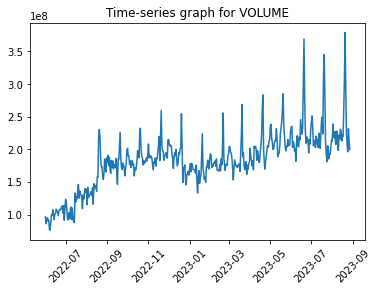

In [3]:
df['TIME_VALUE'] = pd.to_datetime(df['TIME_VALUE'])
df['TIME_VALUE']=df['TIME_VALUE'].dt.date
# df = df[df['TIME_VALUE']>='2021-01-03']
df.set_index('TIME_VALUE', inplace=True)

# df['TIME_VALUE']=df['TIME_VALUE'].dt.date

df = df.asfreq(freq='1D')
df = df.sort_index(ascending = True)
df = df.fillna(value = 0)

f, ax = plt.subplots(1,1)
ax.plot(df['VOLUME'])
ax.set_title('Time-series graph for VOLUME')
ax.tick_params(axis = 'x', rotation = 45)

plt.show()
plt.close()

In [4]:
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 30, center = False).mean()
    rolstd = df[ts].rolling(window = 30, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

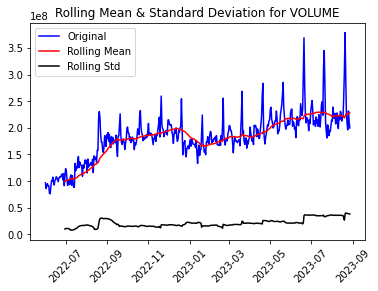

Results of Dickey-Fuller Test:
Test Statistic                  -1.975404
p-value                          0.297460
# Lags Used                     17.000000
Number of Observations Used    435.000000
Critical Value (1%)             -3.445473
Critical Value (5%)             -2.868207
Critical Value (10%)            -2.570321
dtype: float64


In [5]:
test_stationarity(df = df, ts = 'VOLUME')

In [6]:
def plot_transformed_data(df, ts, ts_transform):
    """
    Plot transformed and original time series data
    """
  # Plot time series data
    f, ax = plt.subplots(1,1)
    ax.plot(df[ts])
    ax.plot(df[ts_transform], color = 'red')

  # Add title
    ax.set_title('%s and %s time-series graph' %(ts, ts_transform))

  # Rotate x-labels
    ax.tick_params(axis = 'x', rotation = 45)

  # Add legend
    ax.legend([ts, ts_transform])
  
    plt.show()
    plt.close()
  
    return

In [7]:
# CREATE NEW DF
df_example = df.loc[:,:]

# Transformation - log ts
df_example['ts_log'] = df_example.loc[:,('VOLUME')].apply(lambda x: np.log(x))

# Transformation - 7-day moving averages of log ts
df_example['ts_log_moving_avg'] = df_example.loc[:,('ts_log')].rolling(window = 7, center = False).mean()

# Transformation - 7-day moving average ts
df_example['ts_moving_avg'] = df_example.loc[:,('VOLUME')].rolling(window = 7, center = False).mean()

# Transformation - Difference between logged ts and first-order difference logged ts
df_example['ts_log_diff'] = df_example.loc[:,('ts_log')].diff()

# Transformation - Difference between ts and moving average ts
df_example['ts_moving_avg_diff'] = df_example.loc[:,('VOLUME')] - df_example.loc[:,('ts_moving_avg')]

# Transformation - Difference between logged ts and logged moving average ts
df_example['ts_log_moving_avg_diff'] = df_example.loc[:,('ts_log')] - df_example.loc[:,('ts_log_moving_avg')]

In [8]:
df_example_transform = df_example.loc[:,:].dropna().copy()

In [9]:
# Transformation - Logged exponentially weighted moving averages (EWMA) ts
df_example_transform['ts_log_ewma'] = df_example_transform.loc[:,('ts_log')].ewm(halflife = 7, ignore_na = False, min_periods = 0, adjust = True).mean()

In [10]:
# Transformation - Difference between logged ts and logged EWMA ts
df_example_transform['ts_log_ewma_diff'] = df_example_transform.loc[:,('ts_log')] - df_example_transform.loc[:,('ts_log_ewma')]

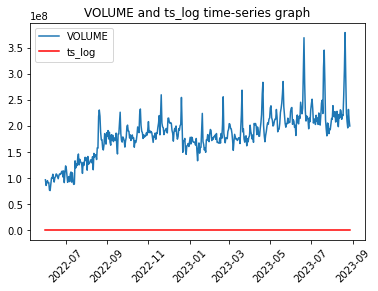

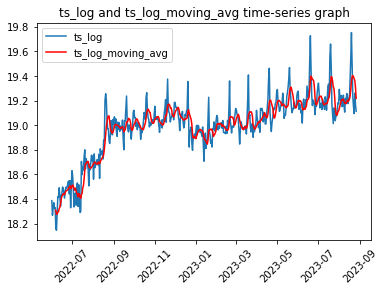

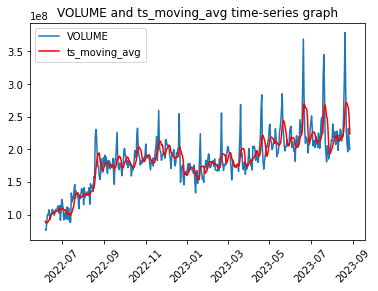

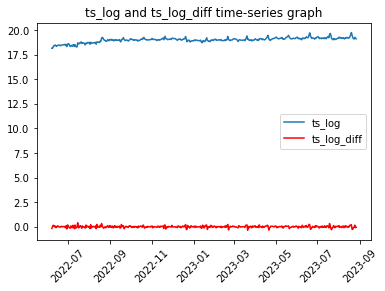

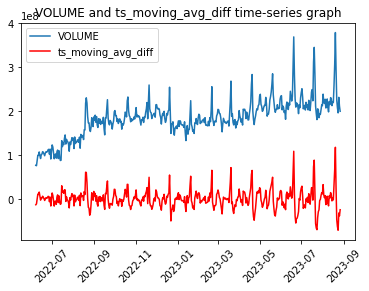

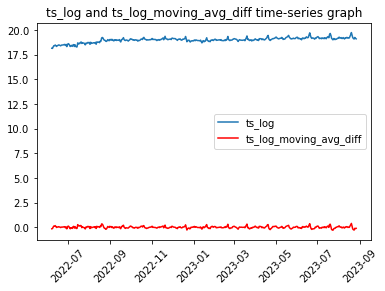

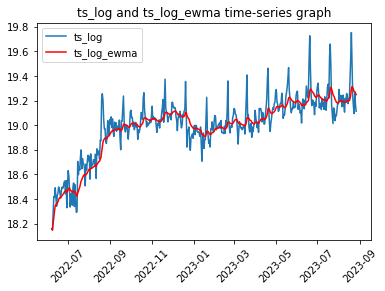

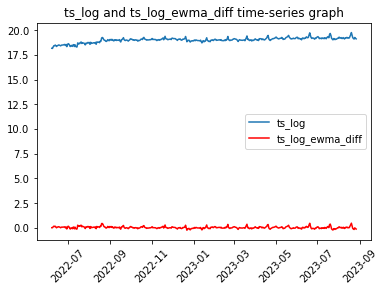

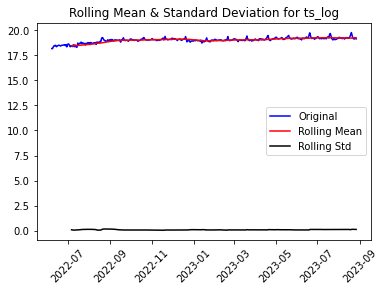

Results of Dickey-Fuller Test:
Test Statistic                  -2.602021
p-value                          0.092580
# Lags Used                     10.000000
Number of Observations Used    436.000000
Critical Value (1%)             -3.445438
Critical Value (5%)             -2.868192
Critical Value (10%)            -2.570313
dtype: float64


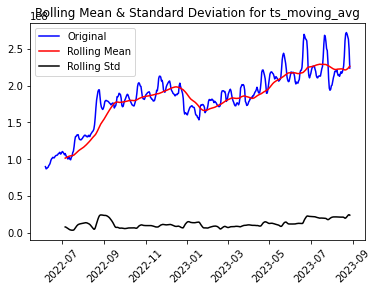

Results of Dickey-Fuller Test:
Test Statistic                  -2.040078
p-value                          0.269281
# Lags Used                     17.000000
Number of Observations Used    429.000000
Critical Value (1%)             -3.445685
Critical Value (5%)             -2.868301
Critical Value (10%)            -2.570371
dtype: float64


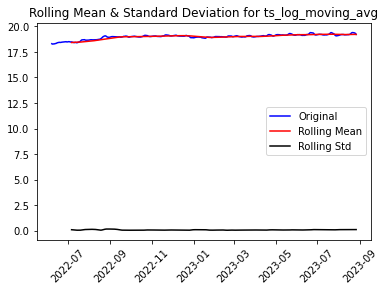

Results of Dickey-Fuller Test:
Test Statistic                  -2.479139
p-value                          0.120633
# Lags Used                     17.000000
Number of Observations Used    429.000000
Critical Value (1%)             -3.445685
Critical Value (5%)             -2.868301
Critical Value (10%)            -2.570371
dtype: float64


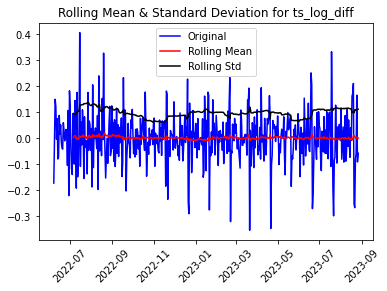

Results of Dickey-Fuller Test:
Test Statistic                -1.084439e+01
p-value                        1.586011e-19
# Lags Used                    9.000000e+00
Number of Observations Used    4.370000e+02
Critical Value (1%)           -3.445403e+00
Critical Value (5%)           -2.868177e+00
Critical Value (10%)          -2.570305e+00
dtype: float64


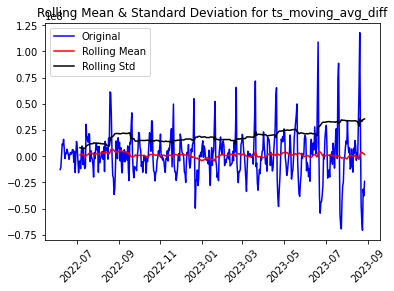

Results of Dickey-Fuller Test:
Test Statistic                -1.077368e+01
p-value                        2.349179e-19
# Lags Used                    7.000000e+00
Number of Observations Used    4.390000e+02
Critical Value (1%)           -3.445334e+00
Critical Value (5%)           -2.868146e+00
Critical Value (10%)          -2.570289e+00
dtype: float64


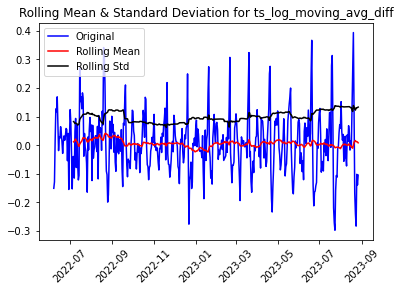

Results of Dickey-Fuller Test:
Test Statistic                -1.051492e+01
p-value                        1.002176e-18
# Lags Used                    7.000000e+00
Number of Observations Used    4.390000e+02
Critical Value (1%)           -3.445334e+00
Critical Value (5%)           -2.868146e+00
Critical Value (10%)          -2.570289e+00
dtype: float64


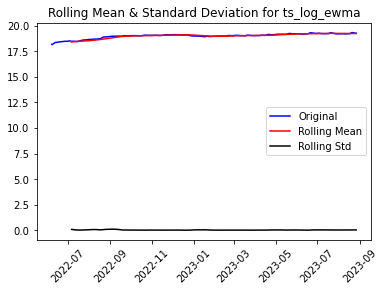

Results of Dickey-Fuller Test:
Test Statistic                  -3.102532
p-value                          0.026366
# Lags Used                      3.000000
Number of Observations Used    443.000000
Critical Value (1%)             -3.445198
Critical Value (5%)             -2.868086
Critical Value (10%)            -2.570257
dtype: float64


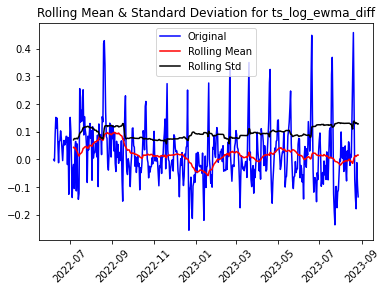

Results of Dickey-Fuller Test:
Test Statistic                -1.004379e+01
p-value                        1.472530e-17
# Lags Used                    2.000000e+00
Number of Observations Used    4.440000e+02
Critical Value (1%)           -3.445164e+00
Critical Value (5%)           -2.868072e+00
Critical Value (10%)          -2.570249e+00
dtype: float64


In [11]:
# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'VOLUME', 
                      ts_transform = 'ts_log')
# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'VOLUME', 
                      ts_transform = 'ts_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'VOLUME', 
                      ts_transform = 'ts_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_ewma')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_ewma_diff')

In [12]:
def plot_decomposition(df, ts, trend, seasonal, residual):
    """
    Plot time series data
    """
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

    ax1.plot(df[ts], label = 'Original')
    ax1.legend(loc = 'best')
    ax1.tick_params(axis = 'x', rotation = 45)

    ax2.plot(df[trend], label = 'Trend')
    ax2.legend(loc = 'best')
    ax2.tick_params(axis = 'x', rotation = 45)

    ax3.plot(df[seasonal],label = 'Seasonality')
    ax3.legend(loc = 'best')
    ax3.tick_params(axis = 'x', rotation = 45)

    ax4.plot(df[residual], label = 'Residuals')
    ax4.legend(loc = 'best')
    ax4.tick_params(axis = 'x', rotation = 45)
    plt.tight_layout()

  # GRAPH
    plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
    plt.show()
    plt.close()

    return

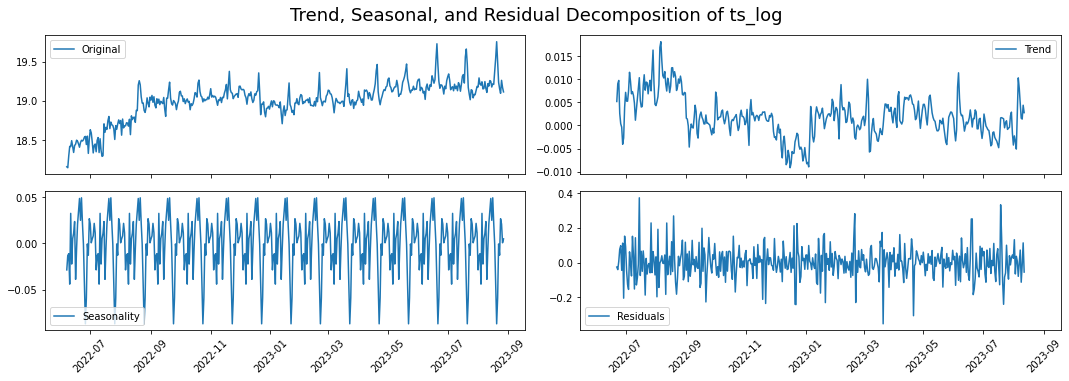

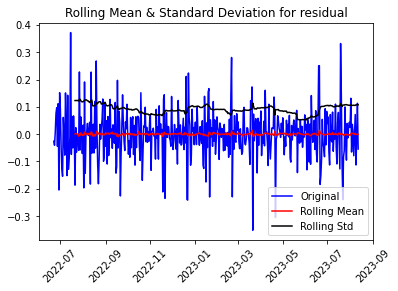

Results of Dickey-Fuller Test:
Test Statistic                -1.025737e+01
p-value                        4.325675e-18
# Lags Used                    1.700000e+01
Number of Observations Used    3.990000e+02
Critical Value (1%)           -3.446846e+00
Critical Value (5%)           -2.868811e+00
Critical Value (10%)          -2.570643e+00
dtype: float64


In [13]:
ts_log_series = pd.Series(df_example_transform['ts_log_diff'])

decomposition = seasonal_decompose(ts_log_series.values, period = 30)

df_example_transform.loc[:,'trend'] = decomposition.trend
df_example_transform.loc[:,'seasonal'] = decomposition.seasonal
df_example_transform.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = df_example_transform, 
                   ts = 'ts_log', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual')

test_stationarity(df = df_example_transform.dropna(), ts = 'residual')

In [14]:
df_example_transform_diff = df_example_transform[['ts_log_diff']]
df_example_transform_actual = df_example_transform[['VOLUME']]

y_diff = df_example_transform_diff['ts_log_diff']
y_actual = df_example_transform_actual['VOLUME']

train_diff = y_diff[:'2023-08-19']
test_diff = y_diff['2023-08-20':]
predict_date = len(y_diff) - len(y_diff[:'2023-08-19'])

train_actual = y_actual[:'2023-08-19']
test_actual = y_actual['2023-08-20':]
predict_date_actual = len(y_actual) - len(y_actual[:'2023-08-19'])

In [15]:
def sarima_grid_search(y, seasonal_period):
    p = d = q = range(0,2)
    pdq = list(itertools.product(p,d,q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p,d,q))]

    mini = float('+inf')

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
                results = mod.fit()

                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMAX{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [16]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    sarima_grid_search(y_diff, 30)

The set of parameters with the minimum AIC is: SARIMAX(1, 0, 1)x(0, 0, 0, 30) - AIC:-854.2532364497499


In [17]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y, order, seasonal_order, seasonal_period, pred_date, y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    # pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred = results.get_prediction(start=pred_date, dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - test_diff) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='OBSERVED')
    y_forecasted.plot(ax=ax, label='ONE-STEP AHEAD FORECAST', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    # pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic = results.get_prediction(start=pred_date, dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - test_diff) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='OBSERVED')
    y_forecasted_dynamic.plot(label='DYNAMIC FORECAST', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8963      0.031     28.597      0.000       0.835       0.958
ma.L1         -0.5493      0.050    -11.090      0.000      -0.646      -0.452
sigma2      4.575e+14        nan        nan        nan         nan         nan


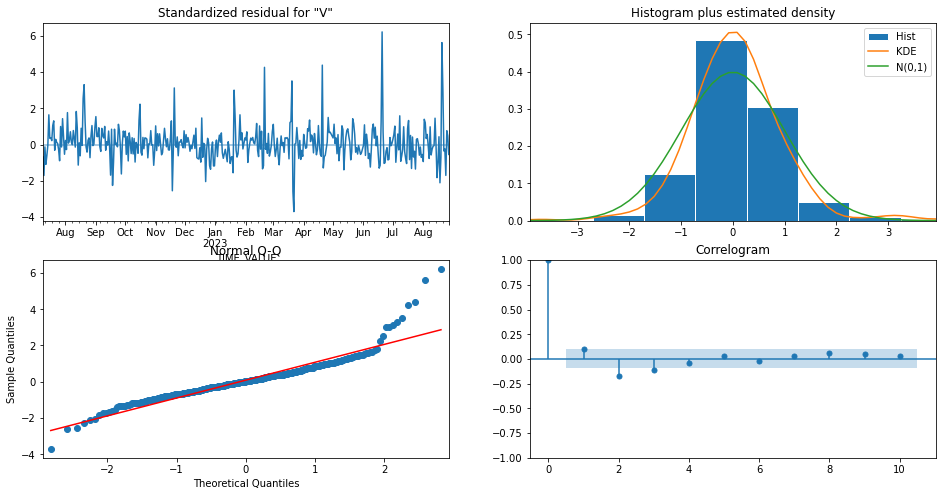

The Root Mean Squared Error of SARIMA with season_length=30 and dynamic = False 225068511.22


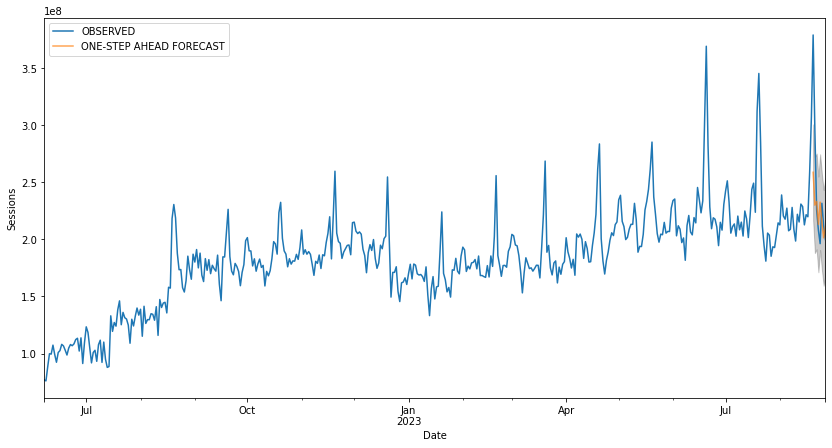

The Root Mean Squared Error of SARIMA with season_length=30 and dynamic = True 191091185.74


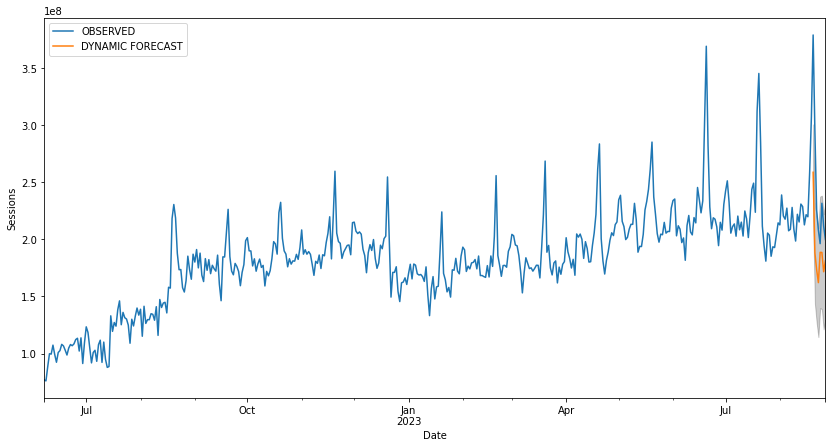

In [18]:
model_sarima = sarima_eva(y_actual, (1,0,1),(0,1,0,30),30,'2023-08-20', test_actual)

In [19]:
def forecast(model, predict_steps, y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='OBSERVED', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='FORECAST')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.05)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # PRODUCE THE FORECASTED TABLES 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

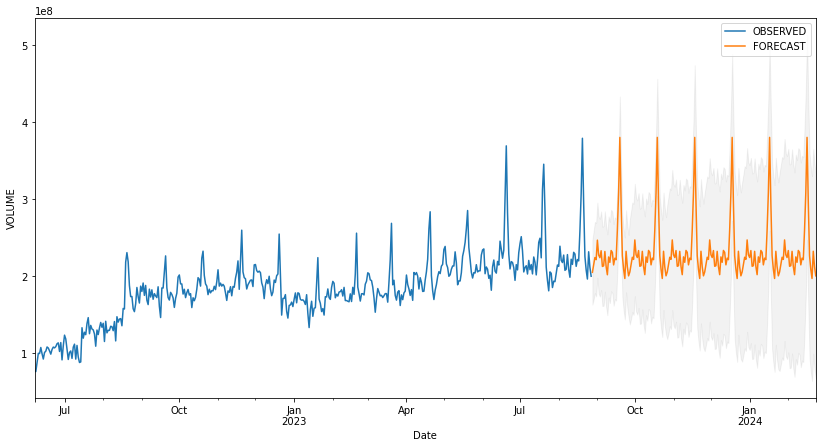

,Date,Predicted_Mean
175,2024-02-19,2.088892e+08
176,2024-02-20,1.969337e+08
177,2024-02-21,2.322470e+08
178,2024-02-22,2.121384e+08
179,2024-02-23,2.003522e+08


In [20]:
final_table = forecast(model_sarima, 180, y_actual)
final_table2 = final_table[['Date','Predicted_Mean']]
final_table2.tail()

In [21]:
# final_table2.to_csv('C:/Users/Laroybafi.Ramadhano/Documents/05. PowerBI/02. Volume Forecast/volume forecast - output - ppob.csv')